# 네이버 영화리뷰 감성 분석

## 0) Import

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split

from konlpy.tag import Komoran

## 1) 데이터 불러오기

In [2]:
train = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [3]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (150000, 3) 
test shape => (50000, 3)


In [6]:
train.columns

Index(['id', 'document', 'label'], dtype='object')

## 2) 훈련 데이터 라벨링 값 비율 확인

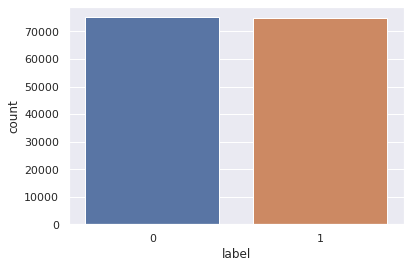

In [7]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

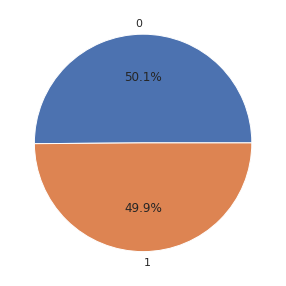

In [8]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## 3) 훈련, 테스트 데이터 결측치 값 확인

In [9]:
train.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [10]:
test.isnull().sum()

id          0
document    3
label       0
dtype: int64

## 4) 데이터 전처리
- 데이터 중복제거(drop_duplicates)  
- 결측치 제거(dropna)  
- 한국어 토크나이저를 활용한 토큰화(Komoran)  
- 불용어 제거(조사,구두점,접미사 종류)
- Bag of Words, word to index, index to word 구현  
- 문장 길이 분포와 적절 최대 문자 길이 지정  
- 최대 문자 길이에 따른 패딩 추가(pad_sequences)

In [11]:
from tqdm import tqdm, trange

In [12]:
tokenizer = Komoran()

def preprocess(train, test):
    train.drop_duplicates(subset=['document'], inplace=True)
    test.drop_duplicates(subset=['document'], inplace=True)
    train = train.dropna()
    test = test.dropna()
    print(f"train shape => {train.shape} \ntest shape => {test.shape}")
    
    train_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in train['document']]
    test_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in test['document']]
    
    exclusion_tags = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC',
                      'SF', 'SP', 'SS', 'SE', 'SO', 'EF', 'EP', 'EC', 'ETN', 'ETM',
                      'XSN', 'XSV', 'XSA']
    
    f = lambda x: x in exclusion_tags
    
    X_train = []
    for i in trange(len(train_tokenized)):
        temp = []
        for j in range(len(train_tokenized[i])):
            if f(train_tokenized[i][j].split('/')[1]) is False:
                temp.append(train_tokenized[i][j].split('/')[0])
        X_train.append(temp)
    
    X_test = []
    for i in trange(len(test_tokenized)):
        temp = []
        for j in range(len(test_tokenized[i])):
            if f(test_tokenized[i][j].split('/')[1]) is False:
                temp.append(test_tokenized[i][j].split('/')[0])
        X_test.append(temp)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(30000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train['label'])), X_test, np.array(list(test['label'])), word_to_index

In [13]:
X_train, y_train, X_test, y_test, word_to_index = preprocess(train, test)

train shape => (146182, 3) 
test shape => (49157, 3)


100%|██████████| 49157/49157 [00:00<00:00, 58823.48it/s]


In [14]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [78]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [15]:
all_data = list(X_train)+list(X_test)

num_tokens = [len(tokens) for tokens in all_data]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포함됩니다.')

토큰 길이 평균: 10.763011994532581
토큰 길이 최대: 140
토큰 길이 표준편차: 8.886926944778248
설정 최대 길이: 28
전체 문장의 0.9356554502685076%가 설정값인 28에 포함됩니다.


### max_len = 28이 아닌 임의 값을 정해 진행했습니다.

In [16]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=30)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=30)

In [17]:
print(f"X_train 1번째 값 길이 : {len(X_train[0])}\nX_test 1번째 값 길이 : {len(X_test[0])}")

X_train 1번째 값 길이 : 30
X_test 1번째 값 길이 : 30


# 모델 구성 및 validation set 구성

    모델 선정 이유
        - LSTM, Stacked LSTM, 1DConv
        - 일반적으로 자연어 분류 모델에서 자주 사용하는 모델들을 선정하였다 
    metrics 선정 이유
        - 데이터 label의 분포가 거의 1:1로 분포하여 accuracy를 사용하였다  
    loss 선정 이유
        - 이진 분류 문제이므로 binary cross entropy가 적절하다

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                  stratify=y_train, random_state=777)

## 모델링 - LSTM

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [20]:
vocab_size = 10000
word_vector_dim = 300

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(units=8))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 3,009,897
Trainable params: 3,009,897
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[mc])

Epoch 1/10
3655/3655 [==============================] - 28s 6ms/step - loss: 0.3912 - accuracy: 0.8223 - val_loss: 0.3610 - val_accuracy: 0.8365

Epoch 00001: val_accuracy improved from -inf to 0.83647, saving model to lstm_best_model.h5
Epoch 2/10
3655/3655 [==============================] - 25s 7ms/step - loss: 0.3094 - accuracy: 0.8642 - val_loss: 0.3540 - val_accuracy: 0.8420

Epoch 00002: val_accuracy improved from 0.83647 to 0.84202, saving model to lstm_best_model.h5
Epoch 3/10
3655/3655 [==============================] - 24s 6ms/step - loss: 0.2650 - accuracy: 0.8868 - val_loss: 0.3728 - val_accuracy: 0.8385

Epoch 00003: val_accuracy did not improve from 0.84202
Epoch 4/10
3655/3655 [==============================] - 23s 6ms/step - loss: 0.2278 - accuracy: 0.9038 - val_loss: 0.3982 - val_accuracy: 0.8349

Epoch 00004: val_accuracy did not improve from 0.84202
Epoch 5/10
3655/3655 [==============================] - 21s 6ms/step - loss: 0.1980 - accuracy: 0.9182 - val_loss: 0.43

In [22]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.5996 - accuracy: 0.8217
[0.599583089351654, 0.8217141032218933]


In [52]:
def draw_graph(history):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [23]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


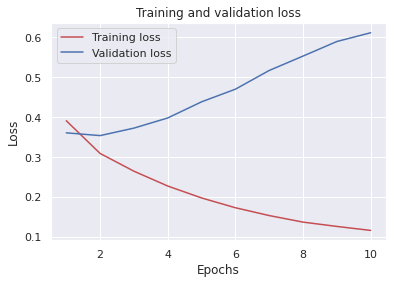

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 모델링 - Stacked LSTM

In [25]:
vocab_size = 10000
word_vector_dim = 300

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(units=8, return_sequences = True))
model.add(tf.keras.layers.LSTM(units=16, return_sequences = False))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('stacked_lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 8)           9888      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,011,505
Trainable params: 3,011,505
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3655/3655 [==============================] - 37s 9ms/step - loss: 0.3916 - accuracy: 0.8192 - val_loss: 0.3581 - val_accuracy: 0.8393

Epoch 00001: val_accuracy improved from -inf to 0.83935, saving model to stacked_lstm_best_model.h5
Epoch 2/20
3655/3655 [==============================] - 33s 9ms/step - loss: 0.3065 - accuracy: 0.8661 - val_loss: 0.3553 - val_accuracy: 0.8393

Epoch 00002: val_accuracy did not improve from 0.83935
Epoch 3/20
3655/3655 [==============================] - 31s 8ms/step - loss: 0.2578 - accuracy: 0.8894 - val_loss: 0.3678 - val_accuracy: 0.8384

Epoch 00003: val_accuracy did not improve from 0.83935
Epoch 4/20
3655/3655 [==============================] - 31s 8ms/step - loss: 0.2167 - accuracy: 0.9094 - val_loss: 0.4093 - val_accuracy: 0.8362

Epoch 00004: val_accuracy did not improve from 0.83935
Epoch 5/20
3655/3655 [==============================] - 30s 8ms/step - loss: 0.1822 - accuracy: 0.9259 - val_loss: 0.4578 - val_accuracy: 0.8323

Epoch

In [27]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

1537/1537 [==============================] - 5s 3ms/step - loss: 0.4502 - accuracy: 0.8349
[0.450198233127594, 0.8348760008811951]


In [28]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


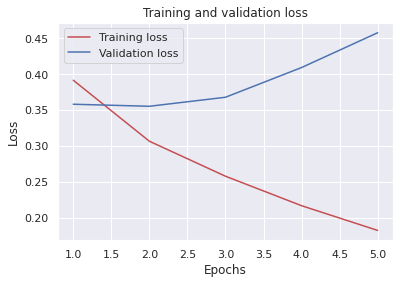

In [29]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- overfitting ...

### 모델링 - CNN

In [30]:
embedding_dim = 256 # 임베딩 벡터의 차원
dropout_ratio = 0.5 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

vocab_size = 10000
word_vector_dim = 300

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('cnn_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         196864    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [31]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3655/3655 [==============================] - 22s 6ms/step - loss: 0.4096 - acc: 0.8114 - val_loss: 0.3612 - val_acc: 0.8361

Epoch 00001: val_acc improved from -inf to 0.83613, saving model to cnn_best_model.h5
Epoch 2/20
3655/3655 [==============================] - 20s 5ms/step - loss: 0.3311 - acc: 0.8582 - val_loss: 0.3579 - val_acc: 0.8423

Epoch 00002: val_acc improved from 0.83613 to 0.84229, saving model to cnn_best_model.h5
Epoch 3/20
3655/3655 [==============================] - 20s 5ms/step - loss: 0.2870 - acc: 0.8789 - val_loss: 0.3621 - val_acc: 0.8411

Epoch 00003: val_acc did not improve from 0.84229
Epoch 4/20
3655/3655 [==============================] - 19s 5ms/step - loss: 0.2541 - acc: 0.8939 - val_loss: 0.3816 - val_acc: 0.8406

Epoch 00004: val_acc did not improve from 0.84229
Epoch 5/20
3655/3655 [==============================] - 19s 5ms/step - loss: 0.2257 - acc: 0.9065 - val_loss: 0.3991 - val_acc: 0.8405

Epoch 00005: val_acc did not improve from 0.8

In [33]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


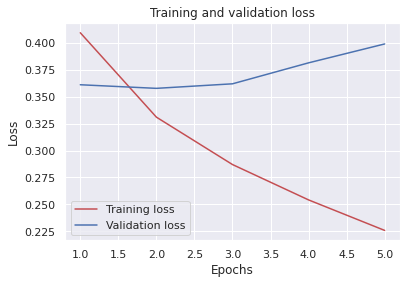

In [34]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [35]:
cnn_model = load_model('cnn_best_model.h5')
lstm_model = load_model('lstm_best_model.h5')
stacked_lstm_model = load_model('stacked_lstm_best_model.h5')

print("\ncnn 모델 테스트 정확도: %.4f" % (cnn_model.evaluate(X_test, y_test)[1]))
print("\nlstm 모델 테스트 정확도: %.4f" % (lstm_model.evaluate(X_test, y_test)[1]))
print("\nstacked lstm 모델 테스트 정확도: %.4f" % (stacked_lstm_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 4s 2ms/step - loss: 0.3575 - acc: 0.8410

cnn 모델 테스트 정확도: 0.8410
1537/1537 [==============================] - 5s 3ms/step - loss: 0.3551 - accuracy: 0.8422

lstm 모델 테스트 정확도: 0.8422
1537/1537 [==============================] - 6s 3ms/step - loss: 0.3578 - accuracy: 0.8409

stacked lstm 모델 테스트 정확도: 0.8409


## 학습된 Embedding 레이어 분석

In [81]:
from gensim.models import Word2Vec

In [82]:
tokenized_data = get_decoded_sentences(X_train, index_to_word)

In [95]:
tokenized_data = [t.split(' ') for t in tokenized_data if '<' not in t]

In [96]:
embedding_dim = 100


model = Word2Vec(  
	sentences = tokenized_data,
	window = 5,  
	min_count = 5,  
	workers = 4,  
	sg = 0  
)

In [97]:
print(model.wv.vectors.shape)

(3306, 100)


In [98]:
word_vectors = model.wv  
vocabs = list(word_vectors.key_to_index)  
vocabs[:20]

['이',
 '영화',
 '보',
 '하',
 '있',
 '것',
 '없',
 '주',
 '같',
 '아니',
 '거',
 '수',
 '않',
 '좋',
 '되',
 '안',
 '너무',
 '말',
 '만들',
 '지']

In [100]:
for sim_word in model.wv.most_similar("영화"):  
    print(sim_word)

('생각', 0.9938402771949768)
('처음', 0.9934661388397217)
('이거', 0.9932091236114502)
('내', 0.9930078983306885)
('이것', 0.9926765561103821)
('최고', 0.992526113986969)
('명작', 0.9924609661102295)
('지금', 0.9921221137046814)
('끝', 0.9920586943626404)
('참', 0.9919236302375793)


## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [36]:
import os

In [37]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [39]:
vector.shape

(100,)

In [67]:
word_vectors.wv.key_to_index

{'<': 34,
 'doc': 12,
 'id': 28,
 '="': 6,
 '5': 75,
 '"': 10,
 'url': 33,
 'https': 26,
 ':': 21,
 '/': 5,
 'ko': 32,
 '.': 0,
 'wikipedia': 31,
 'org': 27,
 'wiki': 30,
 '?': 24,
 'curid': 35,
 '=': 25,
 'title': 29,
 '지미': 5763,
 '카터': 7489,
 '">': 38,
 '제임스': 1377,
 '얼': 3574,
 '주니어': 3290,
 '(': 15,
 ',': 7,
 '1924': 2968,
 '년': 16,
 '10': 101,
 '월': 45,
 '1': 57,
 '일': 49,
 '~': 89,
 ')': 14,
 '는': 4,
 '민주당': 1170,
 '출신': 417,
 '미국': 105,
 '39': 2234,
 '대': 86,
 '대통령': 323,
 '1977': 1813,
 '1981': 1515,
 '이': 3,
 '다': 2,
 '생애': 484,
 '어린': 1470,
 '시절': 432,
 '조지': 1287,
 '아주': 1890,
 '섬터': 53673,
 '카운티': 1646,
 '플': 2029,
 '레인스': 48695,
 '마을': 642,
 '에서': 19,
 '태어났': 656,
 '조지아': 3586,
 '공과': 4556,
 '대학교': 228,
 '를': 17,
 '졸업': 679,
 '하': 11,
 '였': 51,
 '그': 53,
 '후': 106,
 '해군': 965,
 '에': 8,
 '들어가': 1081,
 '전함': 5183,
 '·': 99,
 '원자력': 3550,
 '잠수함': 3498,
 '의': 1,
 '승무원': 5176,
 '으로': 22,
 '1953': 2456,
 '대위': 6026,
 '로': 40,
 '예편': 13256,
 '고': 18,
 '이후': 107,
 '땅콩': 16441,
 '

In [40]:
word_vectors.wv.most_similar('영화')

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

In [41]:
vocab_size = 10000
word_vector_dim = 100

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv.key_to_index:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [42]:
from tensorflow.keras.initializers import Constant

In [46]:
model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=True))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('embedding_cnn_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         77056     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [47]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3655/3655 [==============================] - 17s 5ms/step - loss: 0.6055 - acc: 0.6566 - val_loss: 0.4572 - val_acc: 0.7868

Epoch 00001: val_acc improved from -inf to 0.78678, saving model to embedding_cnn_best_model.h5
Epoch 2/20
3655/3655 [==============================] - 17s 5ms/step - loss: 0.4767 - acc: 0.7776 - val_loss: 0.4037 - val_acc: 0.8134

Epoch 00002: val_acc improved from 0.78678 to 0.81339, saving model to embedding_cnn_best_model.h5
Epoch 3/20
3655/3655 [==============================] - 16s 4ms/step - loss: 0.4330 - acc: 0.8056 - val_loss: 0.3897 - val_acc: 0.8178

Epoch 00003: val_acc improved from 0.81339 to 0.81777, saving model to embedding_cnn_best_model.h5
Epoch 4/20
3655/3655 [==============================] - 17s 5ms/step - loss: 0.4127 - acc: 0.8176 - val_loss: 0.3769 - val_acc: 0.8287

Epoch 00004: val_acc improved from 0.81777 to 0.82868, saving model to embedding_cnn_best_model.h5
Epoch 5/20
3655/3655 [==============================] - 17s 5ms

In [48]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


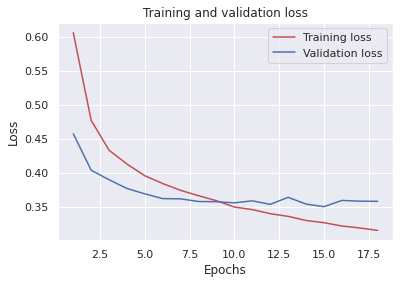

In [49]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [53]:
embedding_cnn_model = load_model('embedding_cnn_best_model.h5')

print("\nWord2vec 임베딩 후 cnn 모델 테스트 정확도: %.4f" % (embedding_cnn_model .evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 3s 2ms/step - loss: 0.3535 - acc: 0.8475

Word2vec 임베딩 후 cnn 모델 테스트 정확도: 0.8475


### lstm 모델 (Trainable True)

In [60]:
from keras.models import Sequential
from keras.layers import *

In [56]:
vocab_size = 10000
word_vector_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=True))
model.add(tf.keras.layers.LSTM(units=8))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('embedding_lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,003,497
Trainable params: 1,003,497
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/10
3655/3655 [==============================] - 24s 6ms/step - loss: 0.4496 - accuracy: 0.7852 - val_loss: 0.3944 - val_accuracy: 0.8200

Epoch 00001: val_accuracy improved from -inf to 0.82002, saving model to embedding_lstm_best_model.h5
Epoch 2/10
3655/3655 [==============================] - 21s 6ms/step - loss: 0.3599 - accuracy: 0.8413 - val_loss: 0.3816 - val_accuracy: 0.8297

Epoch 00002: val_accuracy improved from 0.82002 to 0.82970, saving model to embedding_lstm_best_model.h5
Epoch 3/10
3655/3655 [==============================] - 21s 6ms/step - loss: 0.3305 - accuracy: 0.8574 - val_loss: 0.3780 - val_accuracy: 0.8322

Epoch 00003: val_accuracy improved from 0.82970 to 0.83216, saving model to embedding_lstm_best_model.h5
Epoch 4/10
3655/3655 [==============================] - 21s 6ms/step - loss: 0.3097 - accuracy: 0.8674 - val_loss: 0.3803 - val_accuracy: 0.8350

Epoch 00004: val_accuracy improved from 0.83216 to 0.83504, saving model to embedding_lstm_best_model.h5

In [58]:
predict = model.evaluate(X_test, y_test, verbose=1)
print("\nWord2vec 임베딩 후 lstm 모델 테스트 정확도: %.4f" % (predict[1]))

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3917 - accuracy: 0.8328

Word2vec 임베딩 후 lstm 모델 테스트 정확도: 0.8328


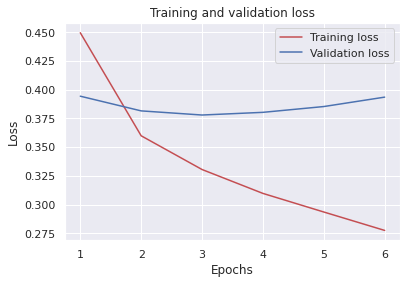

In [59]:
draw_graph(history)

## lstm

In [62]:
vocab_size = 10000
word_vector_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=False))
model.add(tf.keras.layers.LSTM(units=10))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('embedding_lstm_tr_false.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 1,004,451
Trainable params: 4,451
Non-trainable params: 1,000,000
_________________________________________________________________


In [63]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/10
3655/3655 [==============================] - 19s 5ms/step - loss: 0.5014 - accuracy: 0.7521 - val_loss: 0.4781 - val_accuracy: 0.7675

Epoch 00001: val_accuracy improved from -inf to 0.76749, saving model to embedding_lstm_tr_false.h5
Epoch 2/10
3655/3655 [==============================] - 17s 5ms/step - loss: 0.4401 - accuracy: 0.7942 - val_loss: 0.4388 - val_accuracy: 0.7954

Epoch 00002: val_accuracy improved from 0.76749 to 0.79540, saving model to embedding_lstm_tr_false.h5
Epoch 3/10
3655/3655 [==============================] - 18s 5ms/step - loss: 0.4229 - accuracy: 0.8051 - val_loss: 0.4345 - val_accuracy: 0.7983

Epoch 00003: val_accuracy improved from 0.79540 to 0.79827, saving model to embedding_lstm_tr_false.h5
Epoch 4/10
3655/3655 [==============================] - 18s 5ms/step - loss: 0.4121 - accuracy: 0.8116 - val_loss: 0.4283 - val_accuracy: 0.8018

Epoch 00004: val_accuracy improved from 0.79827 to 0.80183, saving model to embedding_lstm_tr_false.h5
Epoch 5

In [64]:
predict = model.evaluate(X_test, y_test, verbose=1)
print("\nWord2vec 임베딩 후 lstm 모델 테스트 정확도: %.4f" % (predict[1]))

1537/1537 [==============================] - 4s 3ms/step - loss: 0.4114 - accuracy: 0.8138

Word2vec 임베딩 후 lstm 모델 테스트 정확도: 0.8138


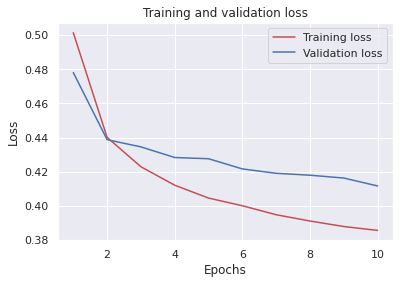

In [66]:
draw_graph(history)

### Stacked LSTM

In [68]:
vocab_size = 10000
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=True))
model.add(tf.keras.layers.LSTM(units=8, return_sequences = True))
model.add(tf.keras.layers.LSTM(units=16, return_sequences = False))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('embedding_stacked_lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 8)           3488      
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 1,005,105
Trainable params: 1,005,105
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3655/3655 [==============================] - 31s 8ms/step - loss: 0.4380 - accuracy: 0.7914 - val_loss: 0.3868 - val_accuracy: 0.8242

Epoch 00001: val_accuracy improved from -inf to 0.82423, saving model to embedding_stacked_lstm_best_model.h5
Epoch 2/20
3655/3655 [==============================] - 30s 8ms/step - loss: 0.3513 - accuracy: 0.8455 - val_loss: 0.3753 - val_accuracy: 0.8298

Epoch 00002: val_accuracy improved from 0.82423 to 0.82980, saving model to embedding_stacked_lstm_best_model.h5
Epoch 3/20
3655/3655 [==============================] - 31s 8ms/step - loss: 0.3248 - accuracy: 0.8598 - val_loss: 0.3718 - val_accuracy: 0.8351

Epoch 00003: val_accuracy improved from 0.82980 to 0.83511, saving model to embedding_stacked_lstm_best_model.h5
Epoch 4/20
3655/3655 [==============================] - 30s 8ms/step - loss: 0.3054 - accuracy: 0.8695 - val_loss: 0.3696 - val_accuracy: 0.8358

Epoch 00004: val_accuracy improved from 0.83511 to 0.83579, saving model to embe

In [71]:
predict = model.evaluate(X_test, y_test, verbose=1)
print("\nWord2vec 임베딩 후 Stacked LSTM 모델 테스트 정확도: %.4f" % (predict[1]))

1537/1537 [==============================] - 5s 3ms/step - loss: 0.3867 - accuracy: 0.8369

Word2vec 임베딩 후 Stacked LSTM 모델 테스트 정확도: 0.8369


## 회고

__배운점__
- Embedding이 성능향상을 내는 것을 볼 수 있었다 (CNN).
    - 안정적인 학습이 가능해지는 것을 확인하였다
    - 하지만 lstm 모델에서는 성능이 향상이 되지 않았다


__아쉬운점__
- tokenizer 별로 성능 정리를 해보고 싶었는데 시간상의 이유로 하지 못해서 아쉽다
- overfitting 문제가 많이 발생해서 이를 해결하기 위한 시도를 좀 더 해보고 싶다
